In [10]:
import tensorflow as tf
import sys
sys.path.insert(0, '/home/ading/dev/empirical-mt')
sys.path.insert(0, '/home/ading/dev/pyflow/')

from skimage import io, img_as_ubyte, color, draw
import numpy as np


import matplotlib.pyplot as plt

from visual_tracking.utils import est_contrast_flow_input_pip

import pandas as pd

import numpy as np
import pyflow

import cv2

from tqdm import tqdm

from scipy.stats.stats import pearsonr 

In [30]:
ne = est_contrast_flow_input_pip.EstimatorOpticFlowInputFunc(dataset_index_filepath='../data/alov300++/alov300_train.csv', input_path='../', fixed_input_dim=76, batch_size=1000, num_epochs=1, shuffle_buffer_size=10000, cache_path='../', cache_id='eval_ds')()

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.string, tf.string, tf.int32, tf.int32)>
intput pipline initilized, input_shpae=({'box': TensorShape([Dimension(None), Dimension(4)]), 'frame2': TensorShape([Dimension(None), Dimension(76), Dimension(76), Dimension(3)]), 'frame1': TensorShape([Dimension(None), Dimension(76), Dimension(76), Dimension(3)]), 'speed': TensorShape([Dimension(None), Dimension(76), Dimension(76)]), 'direction': TensorShape([Dimension(None), Dimension(76), Dimension(76)])}, TensorShape([Dimension(None), Dimension(4)])), input_dtype=({'box': tf.float32, 'frame2': tf.float32, 'frame1': tf.float32, 'speed': tf.float32, 'direction': tf.float32}, tf.float32)


In [31]:
x_in_avg = []
y_in_avg = []
x_out_avg = []
y_out_avg = []

b1s = []
b2s = []
pspeed = []

with tf.Session() as sess:
    i = 1
    while True:
        i = i + 1
        try:
            r = sess.run(ne)
        except tf.errors.OutOfRangeError:
            break
        
        for i in tqdm(range(0, r[1].shape[0])):
            
            speed = r[0]['speed'][i, :, :]
            angle = r[0]['direction'][i, :, :]
            
            b1 = r[0]['box'][i, :]
            b2 = r[1][i, :]
            
            b1s.append(b1)
            b2s.append(b2)
            
            y_min, x_min, y_max, x_max = b1
            
            flow_x = speed * np.cos(angle)
            flow_y = speed * np.sin(angle)

            # compute average of optic flow inside bounding box
            box_mask = np.zeros_like(flow_x, dtype=np.float32)
            y_min, x_min, y_max, x_max = np.round(b1 * 76).astype(np.int32)
            rr, cc = draw.rectangle((y_min, x_min), (y_max, x_max), shape=box_mask.shape)
            box_mask[rr, cc] = 1.

            avg_flow_in_x = np.sum(np.multiply(flow_x, box_mask)) / np.sum(box_mask)
            avg_flow_in_y = np.sum(np.multiply(flow_y, box_mask)) / np.sum(box_mask)
            
            avg_flow_out_x = np.sum(np.multiply(flow_x, 1 - box_mask)) / np.sum(1 - box_mask)
            avg_flow_out_y = np.sum(np.multiply(flow_y, 1 - box_mask)) / np.sum(1 - box_mask)
        
            
            x_in_avg.append(avg_flow_in_x)
            y_in_avg.append(avg_flow_in_y)
            
            pspeed.extend(speed.flatten().tolist())

100%|██████████| 14/14 [00:00<00:00, 1021.01it/s]


In [32]:
b1s = np.stack(b1s, axis=0)
b2s = np.stack(b2s, axis=0)

df = pd.DataFrame.from_dict({'avg_in_x': x_in_avg, 
                             'avg_in_y': y_in_avg, 
                             'b1_v1_x': b1s[:, 1],
                             'b1_v1_y': b1s[:, 0],
                             'b1_v2_x': b1s[:, 3],
                             'b1_v2_y': b1s[:, 2],
                             'b2_v1_x': b2s[:, 1],
                             'b2_v1_y': b2s[:, 0],
                             'b2_v2_x': b2s[:, 3],
                             'b2_v2_y': b2s[:, 2]})

df.to_csv('linear_reg_eval.csv', index=False)
df.shape

(9014, 10)

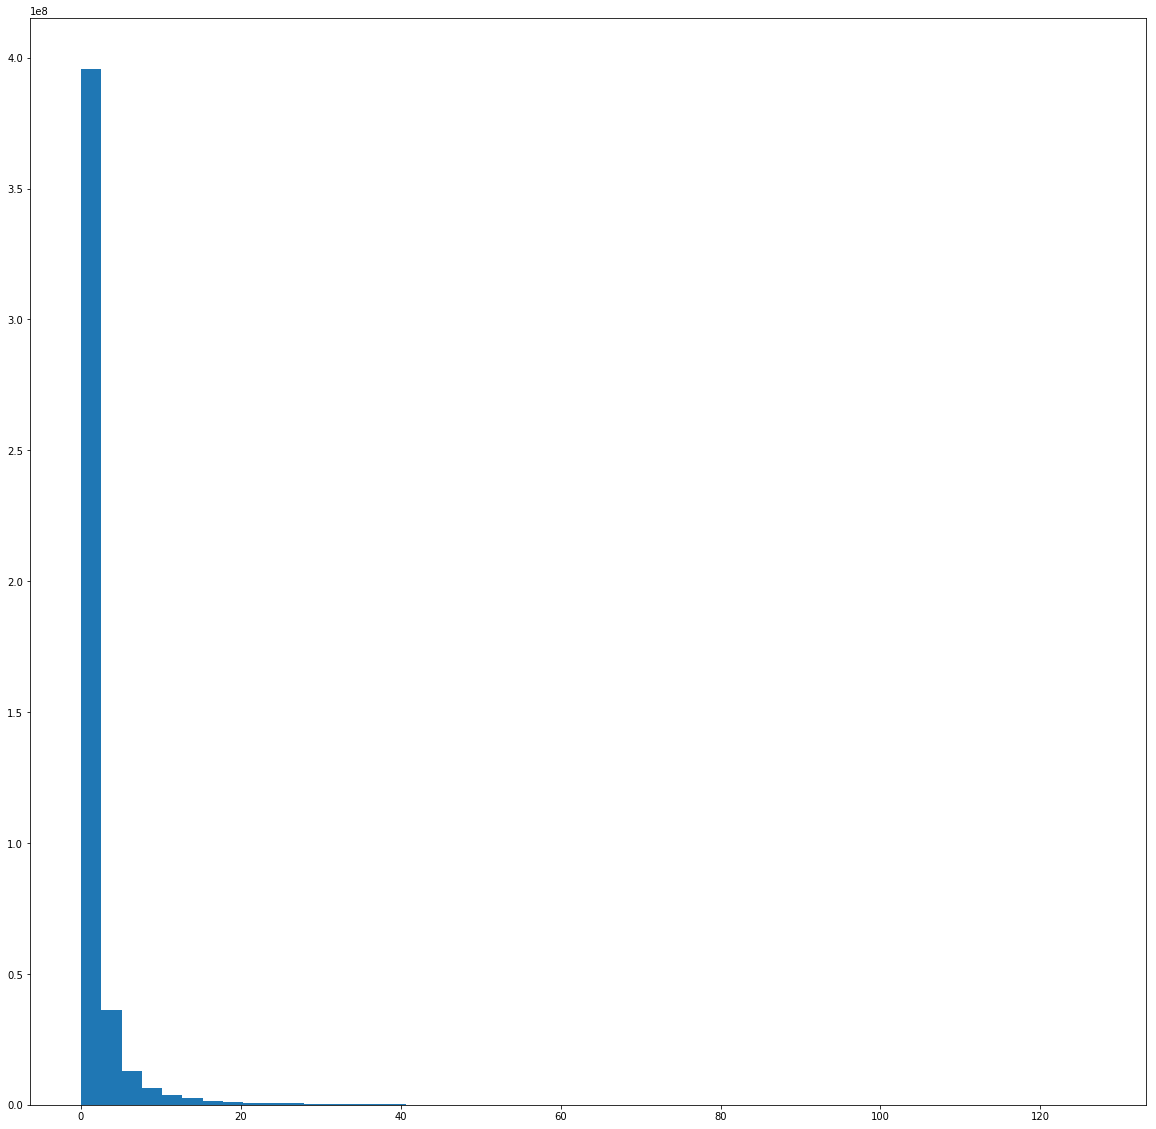

In [51]:
plt.figure(figsize=(20, 20))

plt.hist(pspeed, bins=50)

plt.show()

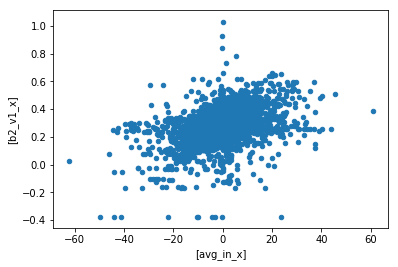

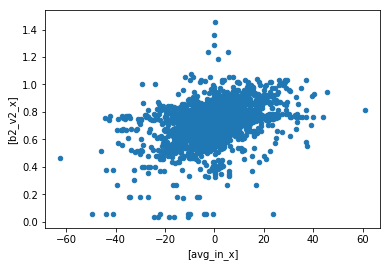

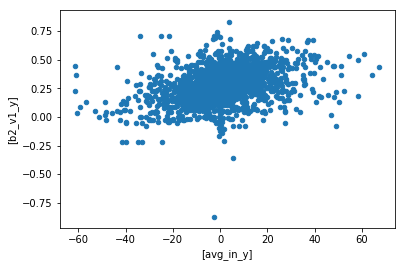

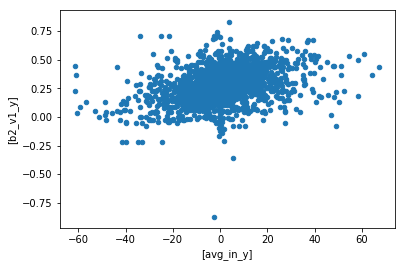

In [57]:
df.plot.scatter(x=['avg_in_x'], y=['b2_v1_x'])
df.plot.scatter(x=['avg_in_x'], y=['b2_v2_x'])
df.plot.scatter(x=['avg_in_y'], y=['b2_v1_y'])
df.plot.scatter(x=['avg_in_y'], y=['b2_v1_y'])

In [33]:
df = pd.read_csv('linear_reg_eval.csv')

In [34]:
df.shape

(9014, 10)

In [35]:
def metrics(p_b2, t_b2, b_1):
    p_b2 = p_b2 - b_1
    t_b2 = t_b2 - b_1
    return {
        'l1': np.linalg.norm(p_b2 - t_b2, ord=1) / t_b2.size,
        'l2': np.linalg.norm(p_b2 - t_b2, ord=2) / t_b2.size,
        'cor_v1_x': np.corrcoef(p_b2[:, 1], t_b2[:, 1]), 
        'cor_v1_y': np.corrcoef(p_b2[:, 0], t_b2[:, 0]), 
        'cor_v2_x': np.corrcoef(p_b2[:, 3], t_b2[:, 3]), 
        'cor_v2_y': np.corrcoef(p_b2[:, 2], t_b2[:, 2]), 
    }

In [40]:
# do nothing baseline

b1 = df[['b1_v1_y', 'b1_v1_x', 'b1_v2_y', 'b1_v2_x']].values
t_b2 = df[['b2_v1_y', 'b2_v1_x', 'b2_v2_y', 'b2_v2_x']].values
p_b2 = df[['b1_v1_y', 'b1_v1_x', 'b1_v2_y', 'b1_v2_x']].values

metrics(p_b2, t_b2, b1)

{'cor_v1_x': array([[ nan,  nan],
        [ nan,   1.]]), 'cor_v1_y': array([[ nan,  nan],
        [ nan,   1.]]), 'cor_v2_x': array([[ nan,  nan],
        [ nan,   1.]]), 'cor_v2_y': array([[ nan,  nan],
        [ nan,   1.]]), 'l1': 0.0021995590424825268, 'l2': 6.9412195677326765e-05}

In [50]:
# linear regression

from sklearn.linear_model import LinearRegression

m = LinearRegression()

df_train = pd.read_csv('linear_reg_train.csv')

m.fit(X=df_train[['avg_in_x', 'avg_in_y', 'b1_v1_y', 'b1_v1_x', 'b1_v2_y', 'b1_v2_x']], y=df_train[['b2_v1_y', 'b2_v1_x', 'b2_v2_y', 'b2_v2_x']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
0.004 * 76

0.304

In [52]:
m.coef_

array([[  7.42574995e-05,   4.33361643e-03,   2.05397840e+03,
          2.85520522e+02,   2.05298154e+03,   2.85524766e+02],
       [  5.64588312e-03,  -6.79476060e-05,  -3.83614236e+03,
         -1.52706297e+04,  -3.83613623e+03,  -1.52716309e+04],
       [  6.65796391e-05,   4.30489472e-03,   5.66256975e+02,
         -1.38112694e+03,   5.67261232e+02,  -1.38112155e+03],
       [  5.65425274e-03,  -8.50371916e-05,  -6.32578176e+03,
         -1.53088829e+04,  -6.32577472e+03,  -1.53078831e+04]])

In [48]:
m.intercept_

array([  1.35965093e-05,   5.07794893e-01,   1.01367314e+00,
         5.06193248e-01])

In [49]:
m.normalize

False

In [39]:
p_b2 = m.predict(df[['avg_in_x', 'avg_in_y', 'b1_v1_y', 'b1_v1_x', 'b1_v2_y', 'b1_v2_x']])

metrics(p_b2, t_b2, b1)

{'cor_v1_x': array([[ 1.        ,  0.68703615],
        [ 0.68703615,  1.        ]]),
 'cor_v1_y': array([[ 1.       ,  0.6261611],
        [ 0.6261611,  1.       ]]),
 'cor_v2_x': array([[ 1.        ,  0.64224526],
        [ 0.64224526,  1.        ]]),
 'cor_v2_y': array([[ 1.        ,  0.68217116],
        [ 0.68217116,  1.        ]]),
 'l1': 0.0016578229124489211,
 'l2': 5.312575296138533e-05}